In [1]:
import numpy as np
from typing import Optional, Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
from scipy.fftpack import fft, ifft, fftshift
from scipy.signal import find_peaks
from ipywidgets import interact, FloatSlider
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib widget

# Motivation: **Maxwell's Equations**

Maxwell's equations describe the behavior of electromagnetic fields in matter. In differential form, they are given by:

$\nabla \times \vec{E}\left(\vec{r},t\right) = -\dfrac{\partial }{\partial t}\vec{B}\left(\vec{r},t\right)$

$\nabla \times \vec{H}\left(\vec{r},t\right) = \vec{j}\left(\vec{r},t\right) + \dfrac{\partial }{\partial t}\vec{D}\left(\vec{r},t\right)$

$\nabla \cdot \vec{D}\left(\vec{r},t\right) = \rho_{ext}\left(\vec{r},t\right)$

$\nabla \cdot \vec{B}\left(\vec{r},t\right) = 0$


When dealing with matter, Maxwell's equations can be expressed in terms of the four macroscopic fields:

* Electric field $\vec{E}\left(\vec{r},t\right)$
* Magnetic flux density $\vec{B}\left(\vec{r},t\right)$
* Electric displacement field $\vec{D}\left(\vec{r},t\right)$
* Magnetic field $\vec{H}\left(\vec{r},t\right)$

Further, these equations depend on the external charge density $\rho_{ext}\left(\vec{r},t\right)$ and the current density $\vec{j}\left(\vec{r},t\right)$ and are linked to the material properties of the medium by the following relations:

$\vec{D}\left(\vec{r},t\right) = \epsilon_0\epsilon_r \vec{E}\left(\vec{r},t\right)$

$\vec{B}\left(\vec{r},t\right) = \mu_0\mu_r \vec{H}\left(\vec{r},t\right)$

1. **Vacuum**: In vacuum, $\epsilon_r = \mu_r = 1$ and $\rho_{ext} = \vec{j} = 0$. Substituting this in the above eqations and solving for the fields, we get: $ \dfrac{\partial^2}{\partial t^2}\vec{E}\left(\vec{r},t\right) - \mathrm{c}^2 \cdot \nabla^2\vec{E}\left(\vec{r},t\right) = 0$, where $\mathrm{c} = \dfrac{1}{\sqrt{\epsilon_0\mu_0}}$ is the speed of light in vacuum. This is the wave equation for the electric field in vacuum. The same equation can be derived for the magnetic field. The general solution of the wave equation in the far field (= plane wave) is given as: $\vec{E}\left(\vec{r},t\right) = \vec{E}_0 \exp\left({i\left(\vec{k}\cdot\vec{r} - \omega t\right)}\right)$, where $\vec{E}_0$ is the electric field amplitude, $\vec{k}$ is the wave vector and $\omega$ is the angular frequency. The wave vector is related to the angular frequency by the dispersion relation: $\omega = \mathrm{c}\left|\vec{k}\right|$. The wave vector is perpendicular to the wave front and points in the direction of wave propagation. The wave vector is related to the wavelength $\lambda$ by $\left|\vec{k}\right| = \dfrac{2\pi}{\lambda}$.

2. **Non-Conducting Isotropic Medium (Dielectric)**: In a non-conducting isotropic medium, $\epsilon_r$ and $\mu_r$ are constants (related to valence band electrons a.k.a. bounded electrons) and $\rho_{ext}$ and $\vec{j}$ depend on the freely movable charges contained in the medium (conduction band electrons). Substituting this in the above eqations and solving for the fields, we get: $\dfrac{\partial^2}{\partial t^2}\vec{E}\left(\vec{r},t\right) - v_g^2 \cdot \nabla^2\vec{E}\left(\vec{r},t\right) = 0$, where $v_g = \dfrac{\mathrm{c}}{\mu_r\epsilon_r}$ is the (group) propagation velocity of the emw inside the medium. The scaling factor is reffered to as the refractive index of the material $n = \dfrac{1}{\epsilon_r\mu_r}.$ As $k$ is related to propagation velocity of the emw, inside a material the effective wavenumber has to be rescaled in regards to the vacuum wavenumber via the aforementioend refractive index, too: $k_{medium} = k = k_0 \cdot n$. The same general solution of the wave equation in the far field (= plane wave) as above still holds valid, though the dielectric properties have to be accoutned for via the effective wave number: $\vec{E}\left(\vec{r},t\right) = \vec{E}_0 \exp\left({i\left(\vec{k_0}n\cdot\vec{r} - \omega t\right)}\right)$. It goes without saying, that just as the wavenumber, also the wavelength is modified as $\lambda_{medium} = \lambda = \dfrac{\lambda_0}{n}$, effectively blue-shifting the emw. Beyond what is described here, the refractive index also has an impact on the polarization and propagation direction of the emw, which is not discussed here.

3. **Conducting Isotropic Medium**: In a conducting isotropic medium, $\epsilon_r$ and $\mu_r$ are constants (related to valence band electrons a.k.a. bounded electrons) and $\rho_{ext}$ and $\vec{j}$ depend on the freely movable charges contained in the medium (conduction band electrons). Further, the electric current density is induced in the material through the incident emw and because of its interaction with the free electrons in the material, resulting in a conductivity $\sigma$, as described in the microscopic form of Ohm's law: $\vec{j} = \sigma \cdot \vec{E}$. This incudec current is accoutned for in the second Maxwell equation above. This equation can now be rewritten in terms of the electric field: $\nabla \times \vec{H} = \vec{j} + \dfrac{\partial }{\partial t}\vec{D} = \sigma\vec{E} + i\omega\epsilon_0\epsilon_r\vec{E} = i\omega\epsilon_0\left(\epsilon_r - i\dfrac{\sigma}{\omega\epsilon_0}\right)\vec{E}$. Thus, a complex relative permittivity is defined as $\tilde{\epsilon_r} = \epsilon_r - i\dfrac{\sigma}{\omega\epsilon_0} = \epsilon^{\prime}_r + i\epsilon^{\prime\prime}_r$. Consequently also the refractive index becomes complex as $\tilde{n} = n^{\prime} + i n^{\prime\prime}$. Further, unsurpsirsingly the wavenumber becomes complex, too: $k_{medium} = k = k_0n^{\prime} + i k_0n^{\prime\prime}$. Substituting this in the above eqations and solving for the fields, we get: $\dfrac{\partial^2}{\partial t^2}\vec{E}\left(\vec{r},t\right) - \dfrac{\sigma}{\tilde{\epsilon}_r\epsilon_0} \dfrac{\partial}{\partial t}\vec{E}\left(\vec{r},t\right) - v_g^2 \cdot \nabla^2\vec{E}\left(\vec{r},t\right) = 0$. The solution of this equation is given as: $\vec{E}\left(\vec{r},t\right) = \vec{E}_0 \exp\left({i\left(\vec{k}^{\prime}\vec{r} - \omega t\right)}\right)\exp\left({-\vec{k}^{\prime\prime}\vec{r}}\right)$. The first exponential term is the same as in the non-conducting isotropic medium. The second exponential term is a damping term, which describes the attenuation of the emw inside the material. Assuming a non-magnetic material ($\mu_r = 1$), an explicit expression for $k$ (the dispersion relation) is obtained: $k^2 = \omega^2\mu_0\epsilon_0\tilde{\epsilon}_r - i\omega\mu_0\sigma = \omega^2\mu_0\epsilon_0\tilde{\epsilon}_r$ and hence $k = k^{\prime} - ik^{\prime\prime}$ with $k^{\prime} =  \omega\sqrt{\dfrac{\epsilon_0\epsilon_r^{\prime}\mu_0}{2}}\sqrt{\sqrt{1 + \left(\dfrac{\sigma}{\epsilon_0\epsilon_r^{\prime}\omega}\right)}+1}$ and $k^{\prime\prime} = \omega\sqrt{\dfrac{\epsilon_0\epsilon_r^{\prime\prime}\mu_0}{2}}\sqrt{\sqrt{1 + \left(\dfrac{\sigma}{\epsilon_0\epsilon_r^{\prime\prime}\omega}\right)}-1}$. The attenuation constant $k^{\prime\prime}$ is related to the penetration depth $\delta = \dfrac{1}{k^{\prime\prime}} = \left(\omega\sqrt{\dfrac{\epsilon_0\epsilon_r^{\prime\prime}\mu_0}{2}}\sqrt{\sqrt{1 + \left(\dfrac{\sigma}{\epsilon_0\epsilon_r^{\prime\prime}\omega}\right)}-1}\right)^{-1}$, which is the distance over which the amplitude of the emw decays by a factor of $\mathrm{e}$. Thus, the penetration depth is related to the conductivity and relative permittivity of the material. 

# Exercise 1.1: **Electromagnetic Waves in Conducting Materials**

*Explain how the parameters of an electromagnetic wave change (compared to a non-conducting
material) when it is traveling inside a conducting material with relative permittivity $\epsilon_r$ , permeability $\mu$, and conductivity $\sigma$. Visualize a linearly-polarized, monochromatic electromagnetic wave traveling within such a material for arbitrary (realistic) choices of dielectric properties.*

Let's assume an electromagentic wave, herafter referred to as emw, originated in a vacuum at location $\vec{r_0}$, of free-space wavelength $\lambda_0$ and propagating into direction $\vec{k}$ observed in the far field, then the following expression can be used to describe the electric field associated with this plane emw:

$\vec{E} = \vec{E_0} \cdot \exp\left( i \left( \vec{k}\vec{r} - \omega t \right) \right)$

$\vec{E_0}$ denotes the electric field amplitude, which is chosen to be kept complex, the angular frequency $\omega = 2\pi\nu = 2\pi \cdot \dfrac{\mathrm{c}}{\lambda}$ (with the speed of light in vacuum $\mathrm{c}$) and $t$ is the time.

Further, the speed of light in vacuum $\mathrm{c}$ is related to the electric permittivity $\epsilon_0$, the magnetic permeability $\mu_0$ of vacuum and the free-space wavelength and frequency $\lambda_0$ and $\nu_0$ by:
$\mathrm{c} = \dfrac{1}{\sqrt{\epsilon_0 \mu_0}} = \lambda_0\nu_0$. 

## 1.1.1 How does the wave-equation change if we consider an electromagnetic wave traveling inside a conducting, linear material?
* See motivation: accounting for $\sigma$ complicates the wave equation, gives rise to a wavenumber that is complex and thus the resulting wave is attenuated
* This dampening is due to the presence of free electrons in the material, which are excited by the emw and thus dissipate energy
* This attenuation prevents the emw from propagating through the material over long distances

## 1.1.2 Which physical meaning can be assigned to the complex part of the wave-number?
* The complex part of the wavenumber describes the attenuation of the emw inside the material

## 1.1.3 How is the penetration-depth $\delta$ deﬁned, and how is it related to $\sigma$ and $\epsilon_r$ ?
* The penetration depth is the distance over which the amplitude of the emw decays by a factor of $\mathrm{e}$
* The penetration depth is related to the conductivity and relative permittivity of the material via $\delta = \dfrac{1}{k^{\prime\prime}} = \left(\omega\sqrt{\dfrac{\epsilon_0\epsilon_r^{\prime\prime}\mu_0}{2}}\sqrt{\sqrt{1 + \left(\dfrac{\sigma}{\epsilon_0\epsilon_r^{\prime\prime}\omega}\right)}-1}\right)^{-1}$

In the following visualization, it is assumed that the emw propagates in $x$-direction. The electric field is visualized in the $x$-$z$-plane. The electric field amplitude is assumed to be constant in $y$-direction. The electric field amplitude is visualized as a function of $x$ and $z$. 

In [2]:
VACUUM_PERMITTIVITY = 8.8541878128e-12 # F/m
VACUUM_PERMEABILITY = 1.25663706212e-6 # H/m
SPEED_OF_LIGHT = 299792458 # m/s

def omega(lambda_0: float) -> float:
    '''Calculates the angular frequency of an EMW.
    Parameters:
    -----------
    lambda_0: float
        Wavelength in m
    
    Returns:
    --------
    float
    '''
    return 2 * np.pi * SPEED_OF_LIGHT / lambda_0

def k_prime(lambda_0: float, eps_prime: float, sigma: float) -> float:
    '''Calculates the real part of the wavenumber of an EMW in a lossy medium.
    Parameters:
    -----------
    lambda_0: float
        Wavelength in m
    eps_prime: float
        Real part of the relative permittivity
    eps_double_prime: float
        Imaginary part of the relative permittivity
    sigma: float
        Conductivity in S/m
    
    Returns:
    --------
    float
    '''
    return omega(lambda_0) * np.sqrt(eps_prime * VACUUM_PERMITTIVITY * VACUUM_PERMEABILITY / 2) * np.sqrt(np.sqrt(1 + (sigma / (eps_prime * VACUUM_PERMITTIVITY * omega(lambda_0)))**2) + 1)

def k_double_prime(lambda_0: float, eps_double_prime: float, sigma: float) -> float:
    '''Calculates the imaginary part of the wavenumber of an EMW in a lossy medium.
    Parameters:
    -----------
    lambda_0: float
        Wavelength in m
    eps_prime: float
        Real part of the relative permittivity
    eps_double_prime: float
        Imaginary part of the relative permittivity
    sigma: float
        Conductivity in S/m
    
    Returns:
    --------
    float
    '''
    try:
        return omega(lambda_0) * np.sqrt(eps_double_prime * VACUUM_PERMITTIVITY * VACUUM_PERMEABILITY / 2) * np.sqrt(np.sqrt(1 + (sigma / (eps_double_prime * VACUUM_PERMITTIVITY * omega(lambda_0)))**2) - 1)
    except ZeroDivisionError:
        return 0
    
def attenuation_term(x: float, lambda_0: float, eps_double_prime: float, sigma: float) -> float:
    '''Calculates the attenuation term of an EMW in a lossy medium.
    Parameters:
    -----------
    x: float
        Position in m
    lambda_0: float
        Wavelength in m
    eps_double_prime: float
        Imaginary part of the relative permittivity
    sigma: float
        Conductivity in S/m
    
    Returns:
    --------
    float
    '''

    return np.exp(-k_double_prime(lambda_0, eps_double_prime, sigma) * x).real
    
def emw(x: float, t: float, lambda_0: float, eps_prime: float, eps_double_prime: float, sigma: float, amplitude: Optional[float] = 1) -> float:
    '''Simple function representing an EMW, to calculate the electric field strength at a given position x at time t.
    Parameters:
    -----------
    x: float
        Position in m
    t: float
        Time in s
    lambda_0: float
        Wavelength in m
    eps_prime: float
        Real part of the relative permittivity
    eps_double_prime: float
        Imaginary part of the relative permittivity
    sigma: float
        Conductivity in S/m
    amplitude: float, optional
        Amplitude of the EMW, default is 1
    
    Returns:
    --------
    float
    '''
    

    try:    # try the case of a lossy medium
        return (amplitude * np.exp(1j*(k_prime(lambda_0, eps_prime, sigma) * x - omega(lambda_0) * t)) * attenuation_term(x, lambda_0, eps_double_prime, sigma)).real  # return the real part of the complex number
    
    except ZeroDivisionError:   # if sigma = 0, the medium is a dielectric or vacuum and the wavenumber is real
        k_0 = 2 * np.pi / lambda_0
        n = np.sqrt(eps_prime + 1j * eps_double_prime).real
        k = k_0 * n
        return (amplitude * np.exp(1j*(k * x - omega(lambda_0) * t))).real # return the real part of the complex number
    

def penetration_depth(k_double_prime: float) -> float:
    '''Calculates the penetration depth of an EMW in a lossy medium.
    Parameters:
    -----------
    k_double_prime: float
        Imaginary part of the wavenumber
    
    Returns:
    --------
    float
    '''
    try:
        return 1 / k_double_prime
    except ZeroDivisionError:
        return np.inf

In [3]:
position = np.linspace(0., 1, 1000)
time = 0
wavelength = 0.19 # m, L1-band GPS with f = 1575.42 MHz
rel_permittivity_real = 1   # lets start in vaccum
rel_permittivity_imag = 0 # no losses, in vaccum
conductivity = 0 # no conductivity, in vaccum


efield = emw(x=position, t=time, lambda_0=wavelength, eps_prime=rel_permittivity_real, eps_double_prime=rel_permittivity_imag, sigma=conductivity)   
attenuator = attenuation_term(x=position, lambda_0=wavelength, eps_double_prime=rel_permittivity_imag, sigma=conductivity)
delta = penetration_depth(k_double_prime=k_double_prime(lambda_0=wavelength, eps_double_prime=rel_permittivity_imag, sigma=conductivity))

interactive(children=(FloatSlider(value=5.0, description="$\\epsilon_r'$", max=10.0, min=1.0, step=0.001), Flo…

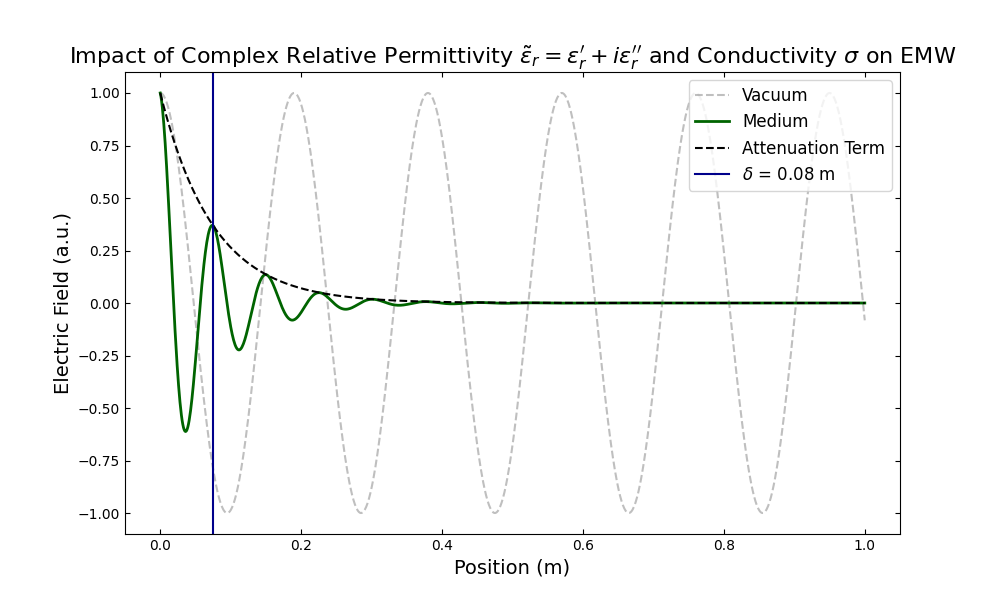

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='both', which='both', direction = 'in', top=True, bottom=True, left=True, right=True)

l0, = ax.plot(position, efield, '--', alpha=0.5, color='gray', label = 'Vacuum')

# Plot the electric field for the medium
l1, = ax.plot(position, efield, linewidth=2, color='darkgreen', label='Medium')

# Plot the electric field for vacuum
l2, = ax.plot(position, attenuator, '--', color='black', label='Attenuation Term')

# Add the vertical line for delta
l3, = ax.plot([delta, delta], [ax.get_ylim()[0], ax.get_ylim()[1]], '-', color='darkblue', label=rf'$\delta$ = {delta:.2f} m')

ax.set_xlabel('Position (m)', fontsize=14)
ax.set_ylabel('Electric Field (a.u.)', fontsize=14)
ax.set_title(r'Impact of Complex Relative Permittivity $\tilde{\epsilon}_r = \epsilon_r^{\prime} + i\epsilon_r^{\prime\prime}$ and Conductivity $\sigma$ on EMW', fontsize=16)
ax.legend(loc='upper right', fontsize=12)

slider_permittivity_real = FloatSlider(value=5.000, min=1.000, max=10.000, step=0.001, description=r"$\epsilon_r'$")
slider_permittivity_imag = FloatSlider(value=50.000, min=0.000, max=100.000, step=0.001, description=r"$\epsilon_r''")
slider_conductivity = FloatSlider(value=0.500, min=0.000, max=1.000, step=0.001, description=r"$\sigma$")
slider_time = FloatSlider(value=0.000, min=0.000, max=1.000, step=0.001, description=r"time [s]")
slider_vertical_line = FloatSlider(value=2.0, min=0.0, max=10.0, step=0.1, description='Vertical Line Position')

@interact(rel_permittivity_real=slider_permittivity_real, rel_permittivity_imag=slider_permittivity_imag, conductivity=slider_conductivity, time = slider_time, vline_pos=slider_vertical_line)
def update_plot(rel_permittivity_real, rel_permittivity_imag, conductivity, time):
    updated_efield_vacuum = emw(x=position, t=time, lambda_0=wavelength, eps_prime=1, eps_double_prime=0, sigma=0)
    updated_efield_medium = emw(x=position, t=time, lambda_0=wavelength, eps_prime=rel_permittivity_real, eps_double_prime=rel_permittivity_imag, sigma=conductivity)
    updated_attenuation_term = attenuation_term(x=position, lambda_0=wavelength, eps_double_prime=rel_permittivity_imag, sigma=conductivity)
    updated_delta = penetration_depth(k_double_prime(lambda_0=wavelength, eps_double_prime=rel_permittivity_imag, sigma=conductivity))
    
    l0.set_ydata(updated_efield_vacuum)
    l1.set_ydata(updated_efield_medium)
    l2.set_ydata(updated_attenuation_term)
    
    l3.set_xdata([updated_delta, updated_delta])
    l3.set_xdata([updated_delta, updated_delta])
    l3.set_label(rf'$\delta$ = {updated_delta:.2f} m')

    ax.legend(loc='upper right', fontsize=12)
    fig.canvas.draw_idle()

